In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import os
import subprocess
import statsmodels.formula.api as smf

import pylab as pl
%pylab inline

# make sure we are at the top of the repo
wd = subprocess.check_output('git rev-parse --show-toplevel', shell = True)
os.chdir(wd[:-1]) #-1 removes \n

Populating the interactive namespace from numpy and matplotlib


### Set up the data

In [2]:
# read in cleaned data
df = gp.read_file('data/citi_docks/citi_docks.shp')
df = df.dropna()
df.head()

,bike,commute_ti,dist_tohom,dist_towor,geometry,income_pc,n_rides,no_vehic_1,no_vehicle,pop,station_id,workers
0,37.500000,751.750000,2.900031,2.009997,POINT (990367.1991470763 201894.5034764804),35375.000000,5223,510.500000,39.500000,1561.000000,302,24.555556
1,0.000000,636.500000,3.340853,1.241825,POINT (985989.2338921009 214874.8949317572),63984.000000,14647,342.500000,112.500000,1043.000000,488,256.000000
2,7.666667,407.000000,3.133704,2.381631,POINT (989421.2936561276 199484.8415778317),32061.666667,8616,112.000000,166.333333,857.000000,502,31.166667
3,14.333333,840.666667,1.032838,1.624516,POINT (990973.8184738184 206381.12757902),62840.000000,8969,584.333333,4.000000,1745.333333,487,4.000000
4,12.250000,647.500000,3.216434,1.936163,POINT (983426.5668231647 204179.6463416842),75221.250000,14414,465.750000,118.500000,1062.000000,128,129.460417


In [3]:
# combine no vehicle units into one column

df['no_vehicle'] = df['no_vehic_1'] + df['no_vehicle']

# calculate nonlinearities
df['dist_tohom2'] = df['dist_tohom']**2
df['log_workers'] = np.log10(df['workers'])

### Develop a simple model first

In [4]:
# regress number of rides on average commute distance
lm = smf.ols('n_rides ~ dist_towor + dist_tohom', data = df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_rides   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     25.30
Date:                Wed, 07 Dec 2016   Prob (F-statistic):           1.06e-10
Time:                        02:40:58   Log-Likelihood:                -2437.8
No. Observations:                 244   AIC:                             4882.
Df Residuals:                     241   BIC:                             4892.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.286e+04   1446.728      8.890      0.000         1e+04  1.57e+04
dist_towor -6358.1506    902.399     -7.046      0.000     -8135.747 -4580.554
dist_tohom  2662.9584    547.332      4.865      0.000      1584.792  3741.125
==============================================================================
Omnibus:                      193.891   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3686.767
Skew:                           2.951   Prob(JB):                         0.00
Kurtosis:                      21.105   Cond. No.                         15.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Investigation

It seems weird that there is a significant positive coefficient on distance to home. What's going on?

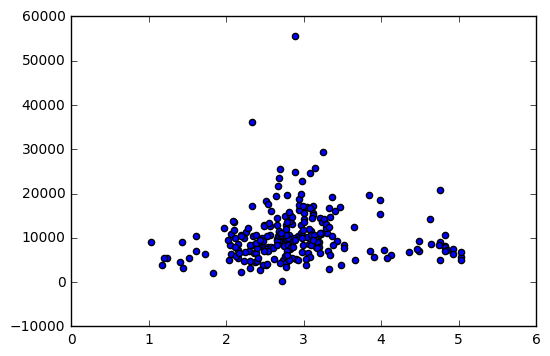

In [5]:
pl.scatter(df['dist_tohom'], df['n_rides'])

There appears to be some non linearity! Can we improve the model with polynomials?

In [6]:
lm = smf.ols('n_rides ~ dist_towor + dist_tohom2 + dist_tohom', data = df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_rides   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     17.75
Date:                Wed, 07 Dec 2016   Prob (F-statistic):           1.93e-10
Time:                        02:40:58   Log-Likelihood:                -2436.6
No. Observations:                 244   AIC:                             4881.
Df Residuals:                     240   BIC:                             4895.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    6365.9440   4456.140      1.429      0.154     -2412.195  1.51e+04
dist_towor  -5702.7152    995.332     -5.729      0.000     -7663.417 -3742.014
dist_tohom2  -624.1948    405.137     -1.541      0.125     -1422.273   173.883
dist_tohom   6473.9374   2533.032      2.556      0.011      1484.123  1.15e+04
==============================================================================
Omnibus:                      195.684   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3772.960
Skew:                           2.986   Prob(JB):                         0.00
Kurtosis:                      21.315   Cond. No.                         165.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Look at a more extensive model

In [7]:
lm = smf.ols('n_rides ~ dist_tohom + dist_tohom2 + dist_towor + \
pop + log_workers + bike + income_pc + commute_ti + no_vehicle', data = df).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_rides   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     6.811
Date:                Wed, 07 Dec 2016   Prob (F-statistic):           1.10e-08
Time:                        02:40:58   Log-Likelihood:                -2432.7
No. Observations:                 244   AIC:                             4885.
Df Residuals:                     234   BIC:                             4920.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept     346.2258   5369.830      0.064      0.949     -1.02e+04  1.09e+04
dist_tohom   7949.2905   2747.504      2.893      0.004      2536.285  1.34e+04
dist_tohom2 -1020.1396    460.087     -2.217      0.028     -1926.581  -113.698
dist_towor  -3791.6577   1309.598     -2.895      0.004     -6371.767 -1211.549
pop            -2.0241      1.324     -1.529      0.128        -4.633     0.584
log_workers  1511.6696    830.380      1.820      0.070      -124.306  3147.645
bike            2.2347     23.843      0.094      0.925       -44.739    49.208
income_pc      -0.0090      0.011     -0.826      0.410        -0.030     0.012
commute_ti      5.0261      3.024      1.662      0.098        -0.932    10.984
no_vehicle     -2.6344      3.469     -0.759      0.448        -9.469     4.200
==============================================================================
Omnibus:                      189.762   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3435.803
Skew:                           2.877   Prob(JB):                         0.00
Kurtosis:                      20.460   Cond. No.                     1.63e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This overall model is not much improved but there is reason to believe some of these variables may be useful

### Feature Selection

In [8]:
df.corr()

,bike,commute_ti,dist_tohom,dist_towor,income_pc,n_rides,no_vehic_1,no_vehicle,pop,station_id,workers,dist_tohom2,log_workers
bike,1.000000,0.188888,-0.098695,0.178724,-0.228035,-0.114596,0.226723,0.217738,0.268545,-0.087861,-0.299643,-0.106066,-0.364642
commute_ti,0.188888,1.000000,0.492830,0.378129,0.131829,-0.012828,0.918859,0.956549,0.933154,-0.038869,-0.179136,0.535578,-0.024018
dist_tohom,-0.098695,0.492830,1.000000,0.577496,0.392924,0.057127,0.324491,0.378632,0.423808,-0.054018,-0.066716,0.982795,0.131228
dist_towor,0.178724,0.378129,0.577496,1.000000,0.014493,-0.303863,0.277029,0.290986,0.463063,-0.043159,-0.458100,0.632008,-0.383834
income_pc,-0.228035,0.131829,0.392924,0.014493,1.000000,0.143678,-0.077015,0.043754,-0.026516,-0.025805,0.135898,0.353997,0.317419
n_rides,-0.114596,-0.012828,0.057127,-0.303863,0.143678,1.000000,-0.022099,-0.019141,-0.106827,-0.040695,0.298800,0.008549,0.322378
no_vehic_1,0.226723,0.918859,0.324491,0.277029,-0.077015,-0.022099,1.000000,0.974479,0.872416,-0.015712,-0.184554,0.365285,-0.087742
no_vehicle,0.217738,0.956549,0.378632,0.290986,0.043754,-0.019141,0.974479,1.000000,0.900787,-0.040896,-0.200286,0.414515,-0.064635
pop,0.268545,0.933154,0.423808,0.463063,-0.026516,-0.106827,0.872416,0.900787,1.000000,-0.056515,-0.266694,0.470091,-0.163366
station_id,-0.087861,-0.038869,-0.054018,-0.043159,-0.025805,-0.040695,-0.015712,-0.040896,-0.056515,1.000000,0.075960,-0.055966,0.068869


### Another model following simple feature selection

In [16]:
lm = smf.ols('n_rides ~ dist_tohom2 + dist_tohom + dist_towor + log_workers + commute_ti', data = df).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_rides   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     11.73
Date:                Wed, 07 Dec 2016   Prob (F-statistic):           3.81e-10
Time:                        02:44:03   Log-Likelihood:                -2434.2
No. Observations:                 244   AIC:                             4880.
Df Residuals:                     238   BIC:                             4901.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      38.7823   5301.464      0.007      0.994     -1.04e+04  1.05e+04
dist_tohom2  -867.0487    428.870     -2.022      0.044     -1711.915   -22.183
dist_tohom   7167.6130   2580.291      2.778      0.006      2084.487  1.23e+04
dist_towor  -4228.5199   1213.304     -3.485      0.001     -6618.707 -1838.333
log_workers  1661.8385    792.960      2.096      0.037        99.722  3223.955
commute_ti      0.5449      0.690      0.790      0.430        -0.814     1.904
==============================================================================
Omnibus:                      192.687   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3627.687
Skew:                           2.927   Prob(JB):                         0.00
Kurtosis:                      20.960   Cond. No.                     1.84e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
df['pred'] = lm.predict()
df['resid'] = df['n_rides'] - df['pred']

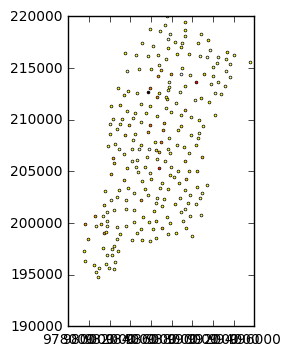

In [11]:

df.plot(column = 'resid', cmap = 'hot_r')